In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy

import numpy as np

import math

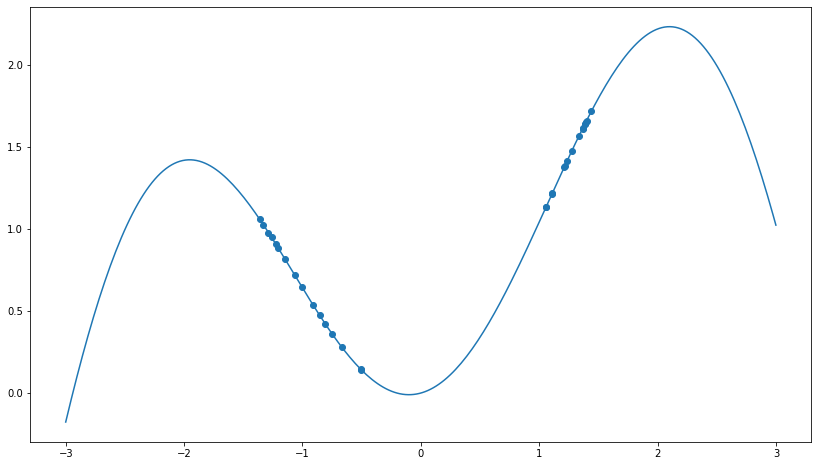

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Prepare some data
def foo(x):
    return x * np.sin(x) + 0.2 * x
#     return x ** 2

N = 32
X = np.concatenate(
    [
        np.random.uniform(low = -1.5, high = -0.5, size = (N // 8 * 4,)),
        np.random.uniform(low = 1, high = 1.5, size = (N // 8 * 4,)),
#         np.random.uniform(low = -2.6, high = -2.3, size = (N // 8 * 2,))
    ])
# X = np.random.uniform(low = -2.6, high = 2.6, size = (N,))
Y = foo(X)

X_GT = np.linspace(-3, 3, num = 256)
Y_GT = foo(X_GT)

fig = plt.figure(figsize = (14, 8))
plt.scatter(X, Y)
plt.plot(X_GT, Y_GT)
plt.show()

dataset_name = "1D-toy-xsin(x)+0.2x"
input_dim = 1

In [3]:
class Recorder(nn.Module):
    
    def __init__(self, wrappedLayer):
        super().__init__()
        self.wrappedLayer = wrappedLayer
        
        self.isRecord = False
        self.isReplay = False
        
    def switchToRecord(self):
        self.isReplay = False
        self.isRecord = True
        
    def switchToReplay(self):
        self.isReplay = True
        self.isRecord = False
        
    def switchToIdentity(self):
        self.isReplay = False
        self.isRecord = False
        
    def forward(self, x):
        
        if self.isRecord:
            z = self.wrappedLayer(x)
            self.buffer = z / x
            self.buffer[self.buffer != self.buffer] = 0 # Set NaN (x = 0) values to 0 (assume actfunc = 0 at x = 0)
            return z

        if self.isReplay:
            return self.buffer * x
        
        return self.wrappedLayer(x)

In [4]:
from tqdm import tqdm

n_trials = 8

# Training dynamics visualization
pivots = [2525, 6773, 1285, 4269, 9275, 528, 5255]
pivot_trial_acts = []

is_uncertain = False
def get_uncertain():
    return is_uncertain
#     return True

def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
#             print("Enabling dropout")
            each_module.train()
            
def disable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
#             print("Disabling dropout")
            each_module.eval()
            
def record(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToRecord()
            
def replay(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToReplay()
            
def recorder_identity(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToIdentity()

class Network(nn.Module):
    
    def __init__(self, hidden_dim = 4096):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nfc = 0
        
        p = 0.5
        self.dropout_rate = p
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            Recorder(torch.nn.ReLU()),
            torch.nn.Dropout(p = p),
            nn.Linear(hidden_dim, hidden_dim),
            Recorder(torch.nn.ReLU()),
            torch.nn.Dropout(p = p),
            nn.Linear(hidden_dim, hidden_dim),
            Recorder(torch.nn.ReLU()),
            torch.nn.Dropout(p = p),
        )
        
        self.model_type = "4-layer-MLP-rec-%f" % p

        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, x):
        return self.head(self.net(x))

device = torch.device('cuda:0')

# lossFn = nn.CrossEntropyLoss()
# lossType = "CrossEnt"

lossFn = lambda output, y : F.mse_loss(output, y)
lossType = "MSE"

accFn  = Accuracy()

trial_logits = []

for i in range(n_trials):
    
    pivot_acts = []
    print("Trial %d" % (i + 1))
    
    hidden_dim = 4096
    net = Network(hidden_dim)
    
    if(i == 0):
        print(net)
        
    optim = torch.optim.AdamW(net.parameters())
    
    net = net.to(device)
    Xs = torch.FloatTensor(X).cuda().view(-1, 1)
    Ys = torch.FloatTensor(Y).cuda().view(-1, 1)
    
#     print(net)
#     print(list(net.modules()))
    
    net.train()
    disable_dropout(net)
    
    steps = 20000
    for ep in tqdm(range(steps)):
        pred = net(Xs)
        loss = lossFn(pred, Ys)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    # Obtain results
    net.eval()
    accuracy = 0
    cnt = 0
    logits = []
    
    Y_GT_pred = net(torch.FloatTensor(X_GT).cuda().view(-1, 1)).detach().cpu().squeeze()
    eval_loss = lossFn(Y_GT_pred, torch.FloatTensor(Y_GT))
        
    trial_logits.append(Y_GT_pred)
    
    print("Final loss: %.4f" % (accuracy * 100.0))

Trial 1
Network(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4096, bias=True)
    (1): Recorder(
      (wrappedLayer): ReLU()
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): Recorder(
      (wrappedLayer): ReLU()
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=4096, bias=True)
    (7): Recorder(
      (wrappedLayer): ReLU()
    )
    (8): Dropout(p=0.5, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:10<00:00, 285.65it/s]


Final loss: 0.0000
Trial 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.78it/s]


Final loss: 0.0000
Trial 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.70it/s]


Final loss: 0.0000
Trial 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.72it/s]


Final loss: 0.0000
Trial 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.70it/s]


Final loss: 0.0000
Trial 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.76it/s]


Final loss: 0.0000
Trial 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.74it/s]


Final loss: 0.0000
Trial 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:09<00:00, 286.80it/s]


Final loss: 0.0000


In [5]:
# Results with MC-dropout
net.eval()
is_uncertain = True

X_GTs = torch.FloatTensor(X_GT).cuda().view(-1, 1)

N_dropout_trials = 512
all_logits = []
recorder_identity(net)

disable_dropout(net)
record(net)

# For recording
Y_GT_pred = net(X_GTs)

enable_dropout(net)
replay(net)

logits = []
for i in range(N_dropout_trials):
    logit = net(X_GTs)
    logits.append(logit.detach().cpu())

all_logits = torch.stack(logits, dim = 0).squeeze()
recorder_identity(net)

is_uncertain = False

In [6]:
print(trial_logits[0])
print(torch.FloatTensor(Y_GT))
print(all_logits.shape)

n_labeled = N

tensor([1.6024, 1.5900, 1.5776, 1.5653, 1.5530, 1.5408, 1.5285, 1.5163, 1.5040,
        1.4918, 1.4795, 1.4673, 1.4550, 1.4428, 1.4305, 1.4183, 1.4060, 1.3938,
        1.3815, 1.3693, 1.3570, 1.3448, 1.3325, 1.3203, 1.3080, 1.2957, 1.2835,
        1.2712, 1.2590, 1.2467, 1.2344, 1.2222, 1.2099, 1.1976, 1.1854, 1.1731,
        1.1608, 1.1486, 1.1363, 1.1241, 1.1118, 1.0995, 1.0873, 1.0750, 1.0627,
        1.0504, 1.0381, 1.0258, 1.0135, 1.0012, 0.9889, 0.9766, 0.9643, 0.9520,
        0.9396, 0.9273, 0.9150, 0.9026, 0.8903, 0.8779, 0.8655, 0.8531, 0.8408,
        0.8284, 0.8160, 0.8036, 0.7912, 0.7788, 0.7664, 0.7539, 0.7415, 0.7290,
        0.7165, 0.7041, 0.6917, 0.6792, 0.6668, 0.6543, 0.6418, 0.6294, 0.6168,
        0.6043, 0.5918, 0.5773, 0.5620, 0.5439, 0.5347, 0.5195, 0.5021, 0.4863,
        0.4755, 0.4690, 0.4650, 0.4603, 0.4549, 0.4491, 0.4426, 0.4358, 0.4276,
        0.4172, 0.4065, 0.3957, 0.3851, 0.3746, 0.3645, 0.3551, 0.3468, 0.3390,
        0.3316, 0.3245, 0.3179, 0.3117, 

In [7]:
torch.save(trial_logits, "%dtrial_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
torch.save(all_logits, "%ddropouts_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))

# trial_logits = torch.load("%dtrial_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
# all_logits = torch.load("%ddropouts_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))

In [8]:
trial_logits_t = torch.stack(trial_logits, dim = 0)
trial_std = trial_logits_t.std(dim = 0)
print(trial_std.shape)

dropout_mean = all_logits.mean(0)
dropout_std  = all_logits.std(0)
print(dropout_mean.shape)

torch.Size([256])
torch.Size([256])


In [9]:
print(dropout_std)

tensor([0.8932, 0.8788, 0.8458, 0.8696, 0.8916, 0.8634, 0.8134, 0.8123, 0.8106,
        0.7995, 0.8068, 0.7706, 0.7843, 0.7863, 0.7989, 0.7828, 0.7575, 0.7820,
        0.7263, 0.7322, 0.7042, 0.6977, 0.7226, 0.6822, 0.6559, 0.6859, 0.6595,
        0.6663, 0.6314, 0.6358, 0.6194, 0.6105, 0.6015, 0.5913, 0.5953, 0.5851,
        0.5702, 0.5944, 0.5186, 0.5376, 0.5047, 0.5242, 0.5003, 0.5022, 0.4960,
        0.4909, 0.4824, 0.4613, 0.4510, 0.4482, 0.4386, 0.4298, 0.4098, 0.4112,
        0.3878, 0.3932, 0.3897, 0.3741, 0.3664, 0.3399, 0.3419, 0.3297, 0.3188,
        0.2910, 0.2965, 0.2826, 0.2704, 0.2647, 0.2627, 0.2358, 0.2539, 0.2292,
        0.2268, 0.2041, 0.1919, 0.1948, 0.1778, 0.1664, 0.1616, 0.1650, 0.1577,
        0.1390, 0.1267, 0.1155, 0.1047, 0.0950, 0.0845, 0.0800, 0.0689, 0.0668,
        0.0472, 0.0339, 0.0236, 0.0190, 0.0183, 0.0172, 0.0158, 0.0289, 0.0402,
        0.0665, 0.0821, 0.1141, 0.1226, 0.1387, 0.1430, 0.1452, 0.1590, 0.1810,
        0.1830, 0.1787, 0.1765, 0.1816, 

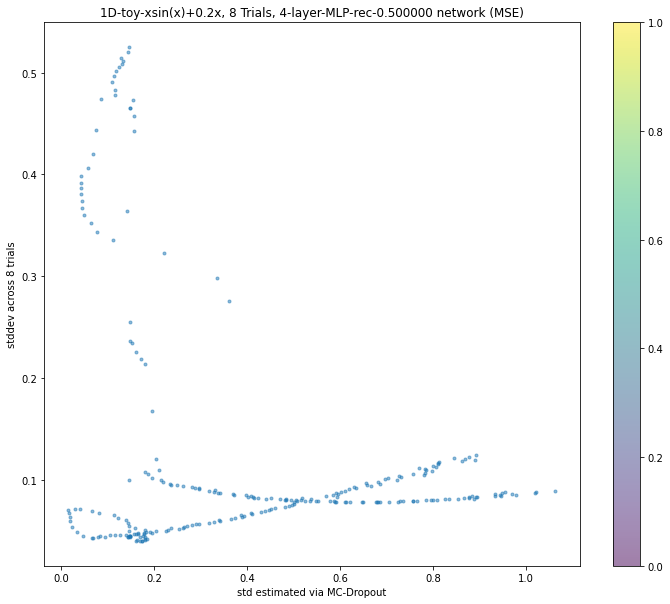

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    dropout_std, trial_std, alpha = 0.5, marker = '.',
    cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("std estimated via MC-Dropout")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

In [11]:
np.set_printoptions(suppress = True)
print(all_logits[0].cpu().numpy())

[1.7292472  1.6523172  1.6804562  3.1583927  2.343098   1.7781773
 2.2697499  0.4076007  0.8918246  1.124452   1.7422633  1.747847
 2.0498106  1.784906   0.99878407 0.7507809  1.4240775  0.57305676
 1.0072317  0.38407296 1.8397522  1.6548964  0.593506   0.842983
 2.2146788  1.5593233  1.3354675  0.9296522  1.1158397  1.3295196
 0.7177657  0.2891285  2.054441   0.64455533 2.172695   1.6392548
 0.27497026 0.93603075 1.5438067  1.4662011  0.09465906 0.25306237
 0.44522023 1.6342328  0.87923753 1.1779172  0.94935894 0.63245654
 1.9456     0.66726595 0.47980338 1.504924   0.69142956 0.6124197
 0.29629558 1.5475438  1.3290501  0.41029495 1.2100623  0.4151178
 1.0177088  1.0175405  1.0267513  0.6560862  1.3207326  0.6287631
 0.4815307  0.90966713 0.9691322  1.010259   0.26837534 0.4435093
 0.45151547 0.6186992  0.81806636 0.6681527  0.3437961  0.6737079
 0.54618686 0.65780175 0.84523845 0.6916373  0.35059378 0.70240104
 0.67142045 0.4991013  0.28768563 0.55672634 0.35222566 0.4356476
 0.32674

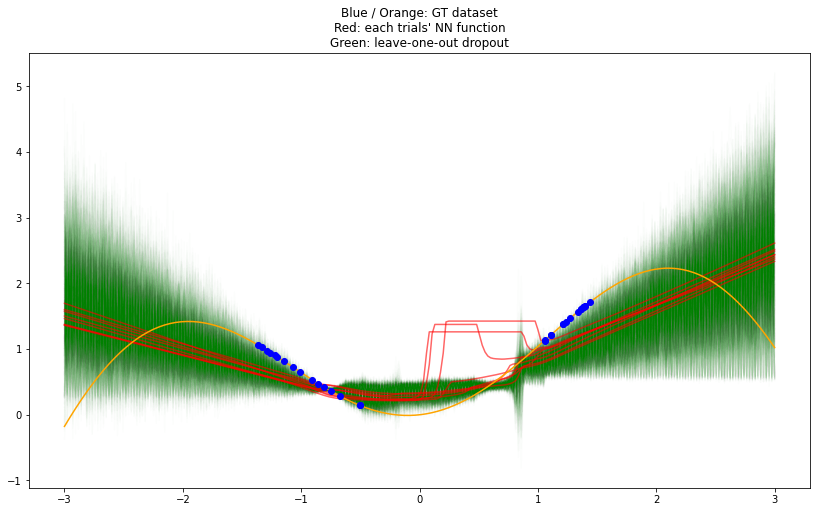

In [17]:
import math

fig = plt.figure(figsize = (14, 8))

# plt.scatter(X, Y_pred, c = 'blue')

for i in range(N):
#     plt.plot(X_GT, Y_GT_pred[i], c = 'blue', alpha = 0.15)
    pass

Y_mean_mean = trial_logits_t.mean(dim = 0).squeeze()
for i in range(N_dropout_trials):
#     plt.plot(X_GT, Y_mean_mean - (all_logits[i] * 0.25), c = 'green', alpha = 0.01)
    plt.plot(X_GT, all_logits[i], c = 'green', alpha = 0.01)
#     break
    pass

# Subnets
# divides = hidden_dim // 4
# for i in range(hidden_dim // divides):
#     Y_act_subnet = Y_act_all[:, (i*divides):((i+1)*divides)].sum(1) * (hidden_dim / divides / 2)
#     Y_act_init_subnet = Y_act_init_all[:, (i*divides):((i+1)*divides)].sum(1) * (hidden_dim / divides / 2)
#     plt.plot(X_GT, ((Y_act_subnet - Y_act_init_subnet)), c = 'green', alpha = 0.5)
#     plt.plot(X_GT, ((Y_act_subnet)), c = 'red', alpha = 0.3)
#     plt.plot(X_GT, ((Y_act_init_subnet)), c = 'blue', alpha = 0.3)
    
for i in range(n_trials):
    plt.plot(X_GT, 1 * (trial_logits_t[i].squeeze() - Y_mean_mean) + Y_mean_mean, c = 'red', alpha = 0.6)
    pass

plt.plot(X_GT, Y_GT, c = 'orange')
plt.scatter(X, Y, c = 'blue', alpha = 1, zorder = 100)

# plt.plot(X_GT, Y_mean[:, 0], c = 'blue')
# plt.plot(X_GT, Y_mean[:, 0] + math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')
# plt.plot(X_GT, Y_mean[:, 0] - math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')

# plt.ylim(-1, 3.0)

# plt.title("Blue: NN (last trial)\nOrange: GT\nRed: each trials\nGreen: MC-stddev (last trial)")
# plt.title("Blue: Dataset\nRed: each trials' NN function\nGreen: MC-bound (stddev, last trial)")
plt.title("Blue / Orange: GT dataset\nRed: each trials' NN function\nGreen: leave-one-out dropout")

plt.show()

In [13]:
# Modify dropout probability
def modify_dropout(m, prob):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
#             print("Disabling dropout")
            each_module.p = prob

new_p = 0.01
modify_dropout(net, new_p)
net.dropout_rate = new_p